# Logistic Regression, Bayes and EM

---

Implementation with numpy only (without sklearn), following OOP.<br>
Constructing a Logistic Regression and Naive Bayes algorithms which uses EM (Expectation Maximization) for calculating the likelihood.<br>
Visualize the results.

---

Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

import warnings
warnings.filterwarnings('ignore')

utils:

In [2]:
# Function for ploting the decision boundaries of a model
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

Load the dataset

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')

X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data

Plotting the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

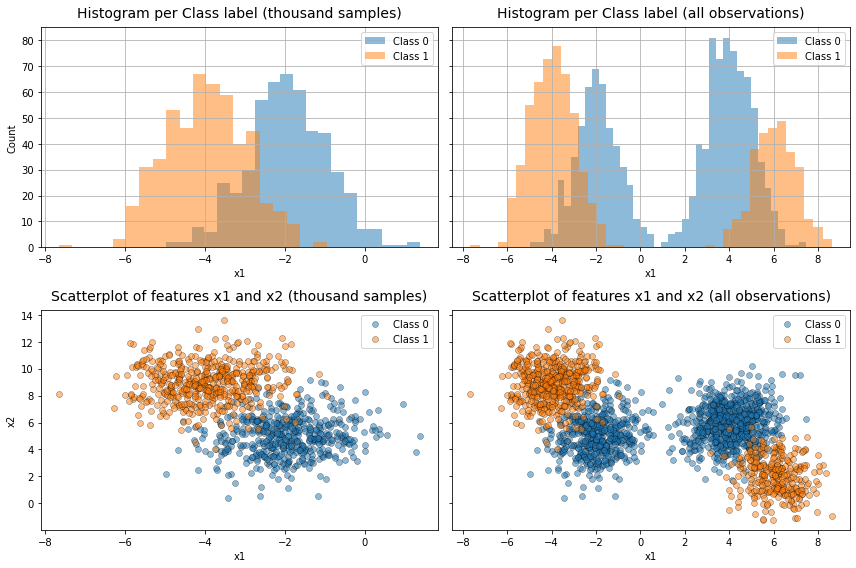

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharey='row', figsize=(12,8))
axes = axes.flatten()

# Plot all thousand samples
train_sample = training_set.head(1000)

x_0_sample = train_sample[train_sample['y'] == 0]
x_1_sample = train_sample[train_sample['y'] == 1]

for data, label in [(x_0_sample, 'Class 0'), (x_1_sample, 'Class 1')]:
    axes[0].hist(data['x1'], bins=20, alpha=0.5, label=label)
    axes[2].scatter(data['x1'], data['x2'], alpha=0.5, edgecolor='k', linewidth=0.5, label=label)

axes[0].grid()
axes[0].set_xlabel('x1'), axes[0].set_ylabel('Count')
axes[0].set_title('Histogram per Class label (thousand samples)', pad=10, fontsize=14)
axes[2].set_title('Scatterplot of features x1 and x2 (thousand samples)', pad=10, fontsize=14)
axes[2].set_xlabel('x1'), axes[2].set_ylabel('x2')
axes[0].legend(), axes[2].legend()


# Plot all observations
x_0 = training_set[training_set['y'] == 0]
x_1 = training_set[training_set['y'] == 1]

for data, label in [(x_0, 'Class 0'), (x_1, 'Class 1')]:
    axes[1].hist(data['x1'], bins=40, alpha=0.5, label=label)
    axes[3].scatter(data['x1'], data['x2'], alpha=0.5, edgecolor='k', linewidth=0.5, label=label)

axes[1].grid()
axes[1].set_xlabel('x1')
axes[1].set_title('Histogram per Class label (all observations)', pad=10, fontsize=14)
axes[3].set_title('Scatterplot of features x1 and x2 (all observations)', pad=10, fontsize=14)
axes[3].set_xlabel('x1')
axes[1].legend(), axes[3].legend()

fig.tight_layout();

---

## Logistic Regression


Implementing the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

The class contains the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

In [5]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = None
        self.bias = 0
        self.J_history = None

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        
        np.random.seed(self.random_state)
        self.theta = np.random.random(size=X.shape[1] + 1)
        
        X, m = self.add_bias(X)
        
        
        self.J_history = [np.inf]
        for _ in range(self.n_iter):
    
            self.theta = self.gradient_descent(X, y, m)
            
            J = self.compute_cost(X, y, m)
            self.J_history.append(J)
            
            if (self.J_history[-2] - self.J_history[-1]) < self.eps:
                break
            
            # if _ % 100 == 0:
                # print(J)


    def gradient_descent(self, X, y, m):
        y_pred = self.predict_proba(X)
        return self.theta - (self.eta * (X.T @ (y_pred - y)))  # Partial derivative

    
    def compute_cost(self, X, y, m):
        y_pred = self.predict_proba(X)
        return (1 / m) * np.sum((-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred)))
        
    
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-(X @ self.theta)))
    
    
    def add_bias(self, X):
        m = X.shape[0]
        X = np.column_stack([np.ones(m), X])
        return X, m
        
    
    def predict(self, X, thresh=0.5):
        """Return the predicted class label"""
        
        X, m = self.add_bias(X)
        return (self.predict_proba(X) >= thresh).astype(int)

In [6]:
log_model = LogisticRegressionGD()

log_model.fit(X=X_training, y=y_training)

In [7]:
y_pred = log_model.predict(X_test)

In [8]:
# Accuracy

np.sum(y_pred == y_test) / y_test.shape[0]

0.804

---

## Cross Validation

Using 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before splitting the data to the folds.

In [9]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

In [10]:
data = training_set.copy()
k = 5

data = data.sample(frac=1).values  # New permutation
X, y = data[:, :-1], data[:, -1]

m = X.shape[0]
batch_size = m // k

scores = {}
for eta in etas:
    for eps in epss: 
        
        fold_scores = []
        
        for i in range(0, m, batch_size):
            X_train, y_train = np.delete(X, np.arange(i, i + batch_size), axis=0), np.delete(y, np.arange(i, i + batch_size), axis=0)
            X_test, y_test = X[i:i + batch_size], y[i:i + batch_size]
            
            log_model = LogisticRegressionGD(eta=eta, eps=eps)
            log_model.fit(X=X_train, y=y_train)
            y_pred = log_model.predict(X_test)
            accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
            
            fold_scores.append(accuracy)
            
        scores[(eta,eps)] = np.mean(fold_scores)
        
        
eta, eps = max(scores, key=scores.get)
max_score = scores[(eta, eps)]

In [11]:
print(f'Chosen eta: {eta}, chosen eps: {eps}, max score: {max_score}')

Chosen eta: 5e-05, chosen eps: 1e-06, max score: 0.8009999999999999


---

## Normal distribution pdf

Normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$

In [12]:
def norm_pdf(data, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * np.square(sigma))) * np.exp((-np.square(data-mu)) / (2 * np.square(sigma)))

---

## Expectation Maximization


Implementing the Expectation Maximization algorithm for gaussian mixture model.

The class holds the distribution params.

Using -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian.

Your class contains the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

In [13]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        
        self.random_state = 42
        
        self.responsibility = None
        
        self.w = None
        self.mu = None
        self.sigma = None
        

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        
        np.random.seed(self.random_state)
        
        self.w = np.ones(self.k) / self.k  # initialize even weights
        self.mu = data.mean(axis=0) / (np.arange(self.k) + 1)
        self.sigma = data.std(axis=0) / (np.arange(self.k) + 1)
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        
        likelihood = norm_pdf(data.reshape(-1, 1), self.mu, self.sigma) * self.w
        responsibility = likelihood / likelihood.sum(axis=1).reshape(-1, 1)
        
        return responsibility, likelihood
        

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        
        new_w = np.mean(self.responsibility, axis=0)
        new_mu = np.mean(self.responsibility * data.reshape(-1, 1), axis=0) / new_w
        new_sigma = np.sqrt(np.mean(self.responsibility * np.square(data.reshape(-1, 1) - new_mu), axis=0) / new_w)   
        
        return new_w, new_mu, new_sigma

    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        
        self.init_params(data)
        
        cost_func = lambda likelihood: -1 * np.sum(np.log(likelihood))
        
        log_likelihoods = [-np.inf]
        for _ in range(self.n_iter):

            self.responsibility, likelihood = self.expectation(data)

            log_likelihoods.append(cost_func(likelihood))

            if log_likelihoods[-1] - log_likelihoods[-2] < self.eps:
                break
            
            self.w, self.mu, self.sigma = self.maximization(data)
            

    def get_dist_params(self):
        return self.mu, self.sigma, self.w
            

    def get_dist_params(self):
        return self.mu, self.sigma, self.w

---

## Naive Bayes


Implementing the Naive Bayes algorithm.

Using the EM algorithm implemented above to find the distribution params for calculating the likelihood.<br>
With these params it is possible to calculate the likelihood probability.<br>
The prior probability can be calculated directly from the training set.

The class contains the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

In [14]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.gaussians = []
        
        self.labels = []
        self.features = []
        

        
    def get_prior(self, y):
        """
        Returns the prior probability of the class according to the dataset distribution.
        """
        
        prior_class_1 = y.sum() / y.shape[0]
        prior_class_0 = 1 - prior_class_1
        
        return prior_class_0, prior_class_1
    
    
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        

        self.prior_class_0, self.prior_class_1 = self.get_prior(y)
        
        self.features = X.shape[1]
        for label in np.unique(y):
            self.labels.append(label)
            
            gaussian = []
            for feature in range(self.features):
                
                class_feature_data = X[y == label][:, int(feature)]
                
                EM_model = EM(k=self.k)
                EM_model.fit(class_feature_data)
                
                gaussian.append(EM_model)
            
            self.gaussians.append(gaussian)
    
    
    def predict(self, X):
        """Return the predicted class label"""
        
        likelihoods = {}
        for label in self.labels:
            for feature in range(self.features):
                likelihood = np.max(self.gaussians[int(label)][int(feature)].expectation(X[:, int(feature)])[1], axis=1)
                likelihoods[(label, feature)] = likelihood
        
        posterior_class_0 = self.prior_class_0 * np.multiply(*[likelihoods[(0, feature)] for feature in range(self.features)])
        posterior_class_1 = self.prior_class_1 * np.multiply(*[likelihoods[(1, feature)] for feature in range(self.features)])
        
        y_pred = np.where(posterior_class_0 < posterior_class_1, 1, 0)
        
        return y_pred

---

## Model evaluation

Plotting the decision boundaries:

In [15]:
X_train, y_train = training_set.head(1000)[['x1','x2']].values, training_set.head(1000)['y'].values
X_test, y_test = test_set.head(500)[['x1','x2']].values, test_set.head(500)['y'].values


def fit_models_print_accuracies(X_train, y_train, X_test, y_test):

    log_model = LogisticRegressionGD(eta=eta, eps=eps)
    log_model.fit(X=X_train, y=y_train)

    gaussian_model = NaiveBayesGaussian(k=2)
    gaussian_model.fit(X=X_train, y=y_train)

    y_pred_log_model = log_model.predict(X_test)
    accuracy_log_model = np.sum(y_pred_log_model == y_test) / y_test.shape[0]

    y_pred_gaussian_model = gaussian_model.predict(X_test)
    accuracy_gaussian_model = np.sum(y_pred_gaussian_model == y_test) / y_test.shape[0]

    print(f"Accuracy of logistic regression: {accuracy_log_model}, Accuracy of GMM: {accuracy_gaussian_model}")
    
    return log_model, gaussian_model

In [16]:
log_model, gaussian_model = fit_models_print_accuracies(X_train, y_train, X_test, y_test)

Accuracy of logistic regression: 0.938, Accuracy of GMM: 0.934


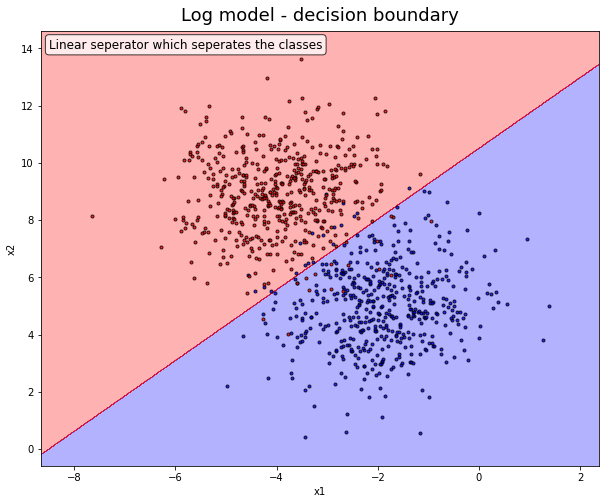

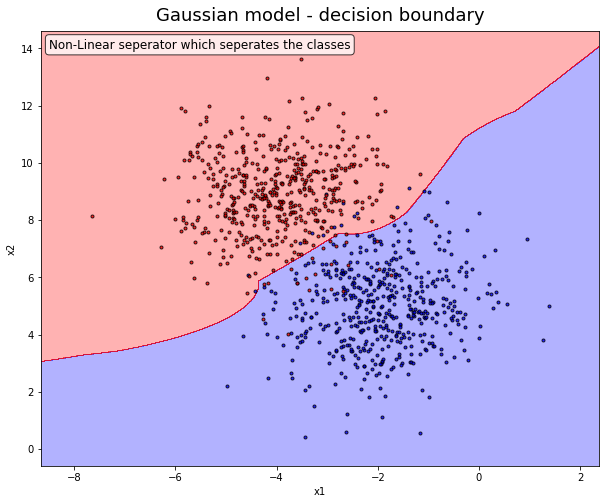

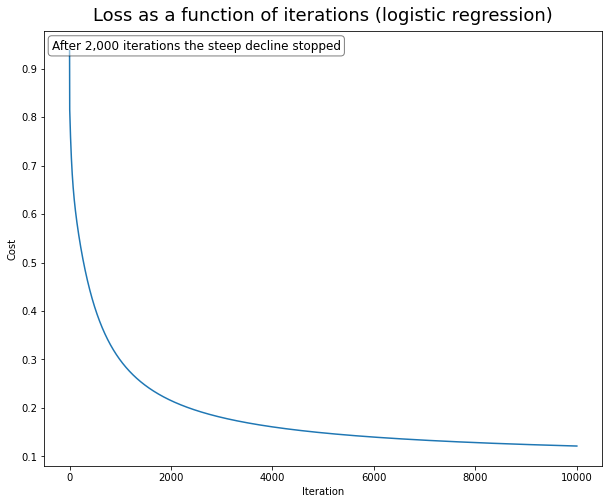

In [17]:
plot_decision_regions(X=X_train, y=y_train, classifier=log_model)
plt.title('Log model - decision boundary', fontsize=18, pad=10)
plt.annotate(text='Linear seperator which seperates the classes',
             fontsize=12, xy=(-8.5, 14), bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
plt.xlabel('x1'), plt.ylabel('x2')
plt.show()


plot_decision_regions(X=X_train, y=y_train, classifier=gaussian_model)
plt.annotate(text='Non-Linear seperator which seperates the classes',
             fontsize=12, xy=(-8.5, 14), bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
plt.title('Gaussian model - decision boundary', fontsize=18, pad=10)
plt.xlabel('x1'), plt.ylabel('x2')
plt.show()


plt.plot(log_model.J_history[1:])
plt.title('Loss as a function of iterations (logistic regression)', fontsize=18, pad=10)
plt.annotate(text="After 2,000 iterations the steep decline stopped",
             fontsize=12, xy=(-350, 0.94), bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

In [18]:
X_train, y_train = training_set[['x1','x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1','x2']].values, test_set['y'].values

log_model, gaussian_model = fit_models_print_accuracies(X_train, y_train, X_test, y_test)

Accuracy of logistic regression: 0.804, Accuracy of GMM: 0.846


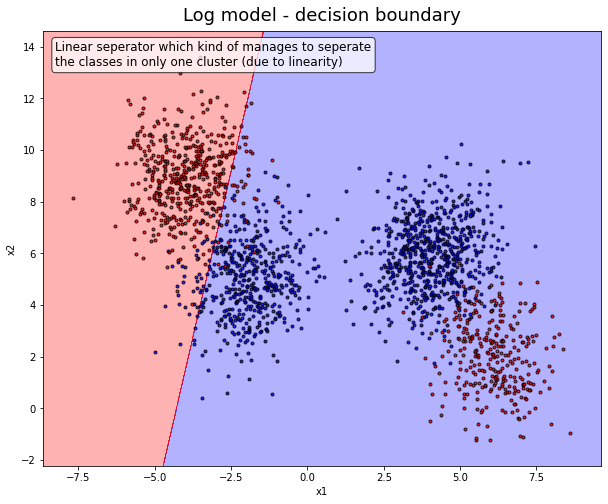

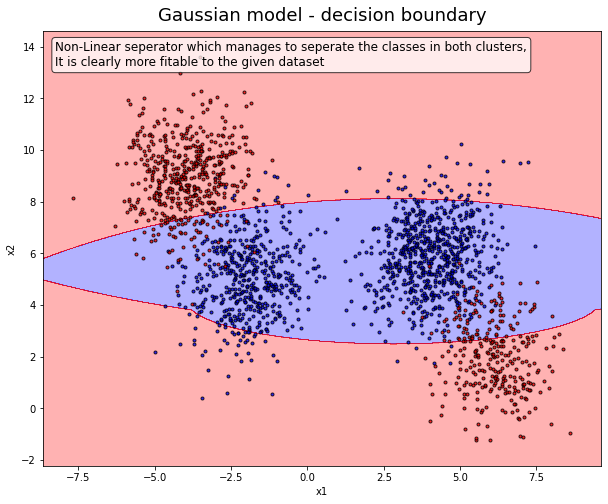

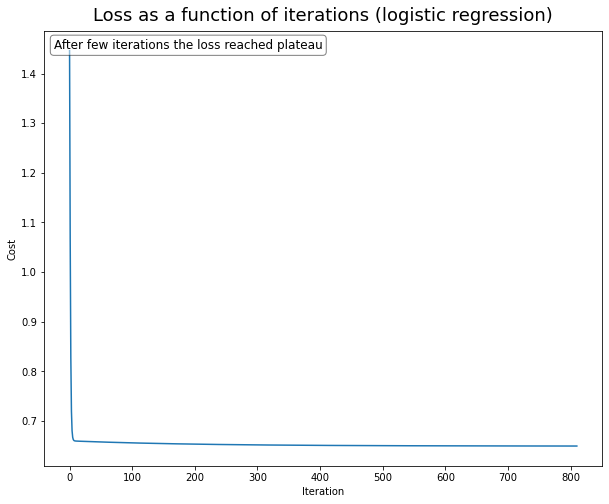

In [19]:
plot_decision_regions(X=X_train, y=y_train, classifier=log_model)
plt.title('Log model - decision boundary', fontsize=18, pad=10)
plt.annotate(text='Linear seperator which kind of manages to seperate\nthe classes in only one cluster (due to linearity)',
             fontsize=12, xy=(-8.25, 13.25), bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
plt.xlabel('x1'), plt.ylabel('x2')
plt.show()


plot_decision_regions(X=X_train, y=y_train, classifier=gaussian_model)
plt.annotate(text='Non-Linear seperator which manages to seperate the classes in both clusters,\nIt is clearly more fitable to the given dataset',
             fontsize=12, xy=(-8.25, 13.25), bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))
plt.title('Gaussian model - decision boundary', fontsize=18, pad=10)
plt.xlabel('x1'), plt.ylabel('x2')
plt.show()


plt.plot(log_model.J_history[1:])
plt.title('Loss as a function of iterations (logistic regression)', fontsize=18, pad=10)
plt.annotate(text="After few iterations the loss reached plateau",
             fontsize=12, xy=(-25, 1.45), bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.xlabel('Iteration'), plt.ylabel('Cost')
plt.show()

---

## Examples with different datasets:

In [20]:
from scipy.stats import multivariate_normal

**Naive Bayes is better:**

In [21]:
x1, x2, x3 = multivariate_normal.rvs(mean=5, cov=1, size=500), multivariate_normal.rvs(mean=5, cov=1, size=500), multivariate_normal.rvs(mean=5, cov=1, size=500)
cluster_1_class_1 = np.column_stack([x1, x2, x3, np.ones(500, dtype=int)])

x1, x2, x3 = multivariate_normal.rvs(mean=15, cov=1, size=500), multivariate_normal.rvs(mean=15, cov=1, size=500), multivariate_normal.rvs(mean=15, cov=1, size=500)
cluster_2_class_1 = np.column_stack([x1, x2, x3, np.ones(500, dtype=int)])

x1, x2, x3 = multivariate_normal.rvs(mean=10, cov=1, size=1000), multivariate_normal.rvs(mean=10, cov=1, size=1000), multivariate_normal.rvs(mean=10, cov=1, size=1000)
cluster_3_class_0 = np.column_stack([x1, x2, x3, np.zeros(1000, dtype=int)])

In [22]:
dataset_0 = np.vstack([cluster_1_class_1, cluster_2_class_1, cluster_3_class_0])

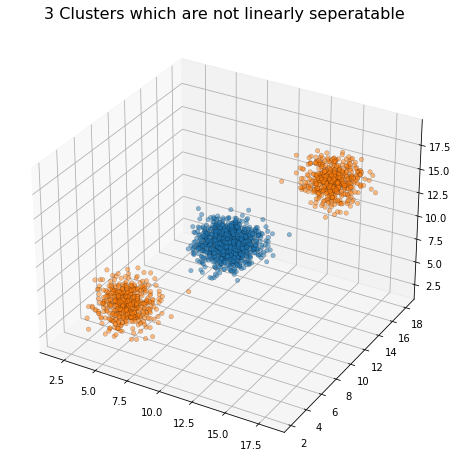

In [23]:
ax = plt.axes(projection='3d')

xdata = dataset_0[:, 0]
ydata = dataset_0[:, 1]
zdata = dataset_0[:, 2]

ax.scatter3D(xdata, ydata, zdata, c=np.where(dataset_0[:, 3] == 0, 'tab:blue', 'tab:orange'), alpha=0.5, edgecolor='k', linewidth=0.25)
ax.set_title('3 Clusters which are not linearly seperatable', fontsize=16);

In [24]:
np.random.seed(seed=42)
dataset = np.random.permutation(dataset_0)

X_train, y_train = dataset[:-300, :-1], dataset[:-300, -1]
X_test, y_test = dataset[-300:, :-1], dataset[-300:, -1]


log_model, gaussian_model = fit_models_print_accuracies(X_train, y_train, X_test, y_test)

Accuracy of logistic regression: 0.45666666666666667, Accuracy of GMM: 1.0


We created 3 clusters that cannot be seperated linearly (linear seperators will suffer from low accuracy).<br>
Those clusters are easily seperable by Naive Bayes because the clusters are sparse and the observations for each cluster are dense (low covariance).

---

**Logistic Regression is better:**

In [25]:
correlated = multivariate_normal.rvs(mean=5, cov=1, size=1000)

x1, x2, x3 = correlated, correlated, multivariate_normal.rvs(mean=30, cov=1, size=1000)
cluster_1_class_0 = np.column_stack([x1, x2, x3, np.zeros(1000, dtype=int)])


correlated = multivariate_normal.rvs(mean=5, cov=1, size=1000)

x1, x2, x3 = correlated, correlated, multivariate_normal.rvs(mean=5, cov=1, size=1000)
cluster_2_class_1 = np.column_stack([x1, x2, x3, np.ones(1000, dtype=int)])

In [26]:
dataset_1 = np.vstack([cluster_1_class_0, cluster_2_class_1])

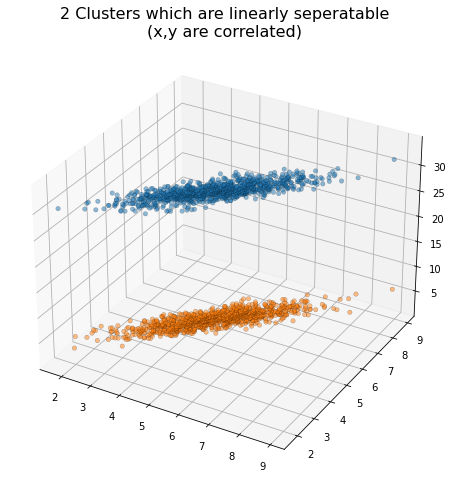

In [27]:
ax = plt.axes(projection='3d')

xdata = dataset_1[:, 0]
ydata = dataset_1[:, 1]
zdata = dataset_1[:, 2]

ax.scatter3D(xdata, ydata, zdata, c=np.where(dataset_1[:, 3] == 0, 'tab:blue', 'tab:orange'), alpha=0.5, edgecolor='k', linewidth=0.25)
ax.set_title('2 Clusters which are linearly seperatable\n(x,y are correlated)', fontsize=16);

In [28]:
dataset_1 = np.random.permutation(dataset_1)

X_train, y_train = dataset_1[:-300, :-1], dataset_1[:-300, -1]
X_test, y_test = dataset_1[-300:, :-1], dataset_1[-300:, -1]


log_model, gaussian_model = fit_models_print_accuracies(X_train, y_train, X_test, y_test)

Accuracy of logistic regression: 1.0, Accuracy of GMM: 0.49666666666666665


We created 2 clusters, x and y are highly correlated, and z is not correlated with neither.<br>
We know that Naive Bayes performes poorly if there are dependent features (correlated features) fitted into the model.<br>
Logistic Regression is less prone to this problem as the repeating features are taken into consideration in the optimization process, compensating for the repetition.

---